<a href="https://colab.research.google.com/github/sudeepds/recommender-systems/blob/main/Book_Recommender_System_Using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book Recommender System
Reference: https://www.kaggle.com/tannergi/book-recommendation-system/notebook
Dataset: https://github.com/zygmuntz/goodbooks-10k
Using Tensor Flow

In [ ]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
dataset = pd.read_csv("./drive/MyDrive/Datasets/goodbooks-10k/ratings.csv")

In [ ]:
dataset.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [ ]:
dataset.shape

(5976479, 3)

In [ ]:
#Splitting train and test sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
test.shape

(1195296, 3)

In [ ]:
# Number of Users
n_users = len(dataset.user_id.unique())
n_users

53424

In [ ]:
# Number of books
n_books = len(dataset.book_id.unique())
n_books

10000

First we can try creating a simple dot product between the book embedding and user embeddings. 
Embeddings are the word(here book and user id) representations in the vector space. It depicts the surroundings of a given word. We will use Keras's Embedding class for this purpose. 
Here we are using individual unconnected Tensors and later creating a Model() out of it. Its a multi entry model and there is no hidden layer. 

In [ ]:
# Input defines the entry of the tensor. Here we are indicating the shape of the input vector that this tensor flow must expect. 
# This is [1] because we will be passing only single column(vector) i.e., user_id or book_id to the tensor.
book_input = Input(shape=[1], name="Book-Input")
#input size is number of unique book ids + 1
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
#using Keras's Flatten class to flatten the embedding matrix from size n_books x 5 to n_books*5. For example, n_books is 10 then initial matrix will be 
# of size 10 x 5. Using flatten, we are converting it to 50 x 1 vector. 
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# Doing same user_id
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing Dot product
prod = Dot(name='Dot-Product', axes=1)([book_vec, user_vec])

# Creating a Model out of above all
model = Model([book_input, user_input], prod)
#here in compile() first param is the optimizer and 2nd is the loss function
model.compile('adam', 'mean_squared_error')

We will use fit() method for training the model. First parameter is a list of inputs as its a multi input tensor. second parameter is the target attribute i.e., ratings column. We will also try to fetch a saved trained model if it exists, if not then train it and then save it. We can save it in either ".h5" format or ".keras" format. 


Epoch 1/5
149412/149412 [==============================] - 847s 6ms/step - loss: 0.9197
Epoch 2/5
149412/149412 [==============================] - 835s 6ms/step - loss: 0.7732
Epoch 3/5
149412/149412 [==============================] - 832s 6ms/step - loss: 0.7351
Epoch 4/5
149412/149412 [==============================] - 833s 6ms/step - loss: 0.7193
Epoch 5/5
149412/149412 [==============================] - 828s 6ms/step - loss: 0.7104


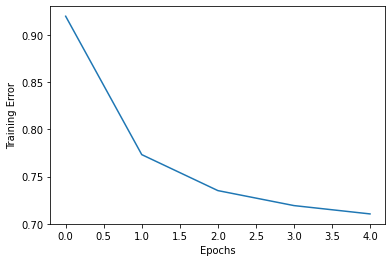

In [ ]:
from keras.models import load_model
if os.path.exists('./drive/MyDrive/Models/book_recommender_model.keras'):
    model = load_model('./drive/MyDrive/Models/book_recommender_model.keras')
else:
    history = model.fit([train.book_id, train.user_id], train.rating, epochs=5, verbose=1)
    model.save('./drive/MyDrive/Models/book_recommender_model.keras')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [ ]:
# Cross validating the model
model.evaluate([test.book_id, test.user_id], test.rating)

37353/37353 [==============================] - 45s 1ms/step - loss: 0.7774


0.7773780226707458

Now as the model is trained and evaluated, we will use it to make predictions. 
Ideally, this prediction should be done 

In [ ]:
predictions = model.predict([test.book_id.head(10), test.user_id.head(10)])
[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.1906898] 3
[3.0355756] 4
[5.0599427] 5
[2.364427] 2
[3.060744] 4
[4.026468] 4
[3.7945328] 4
[4.15826] 4
[4.418781] 5
[3.2861717] 4


[None, None, None, None, None, None, None, None, None, None]

Creating a fully connected Neural Network. It will have Embedding and Flatten steps but after that it will be put into the neural network as input. The output layer would have only one neuron which will provide the predicted rating.
We will Concatenate the flattened vectors of both user and book ids and then use it an an input for the neural network.

In [ ]:
from keras.layers import Concatenate
concat = Concatenate()([book_vec, user_vec])

# adding fully connected network
l1 = Dense(128, activation='relu')(concat)
l2 = Dense(32, activation='relu')(l1)
out = Dense(1)(l2)

# creating a model and compiling
model2 = Model([book_input, user_input], out)
model2.compile('adam', 'mean_squared_error')

Epoch 1/5
149412/149412 [==============================] - 974s 7ms/step - loss: 0.6476
Epoch 2/5
149412/149412 [==============================] - 959s 6ms/step - loss: 0.6434
Epoch 3/5
149412/149412 [==============================] - 967s 6ms/step - loss: 0.6401
Epoch 4/5
149412/149412 [==============================] - 961s 6ms/step - loss: 0.6375
Epoch 5/5
149412/149412 [==============================] - 973s 7ms/step - loss: 0.6352


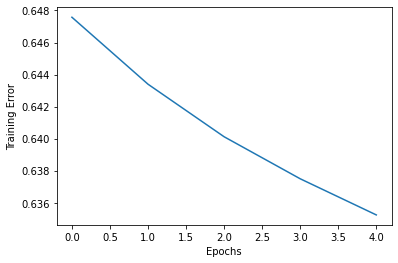

In [ ]:
from keras.models import load_model

if os.path.exists('./drive/MyDrive/Models/book_recommender_model2.keras'):
    model2 = load_model('./drive/MyDrive/Models/book_recommender_model2.keras')
else:
    history = model2.fit([train.book_id, train.user_id], train.rating, epochs=5, verbose=1)
    model2.save('./drive/MyDrive/Models/book_recommender_model2.keras')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [ ]:
model2.evaluate([test.book_id, test.user_id], test.rating)

37353/37353 [==============================] - 52s 1ms/step - loss: 0.6848


0.6848421096801758

In [ ]:
predictions = model2.predict([test.book_id.head(10), test.user_id.head(10)])
[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.1680331] 3
[3.4820337] 4
[4.919308] 5
[2.036648] 2
[3.5031645] 4
[3.7255845] 4
[4.4913197] 4
[4.219663] 4
[4.2823057] 5
[3.4609041] 4


[None, None, None, None, None, None, None, None, None, None]

Peeking into Embeddings

In [ ]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [ ]:
book_em_weights[0:5]

array([[-0.03041469,  0.01880708, -0.04532912, -0.02609667, -0.02700861],
       [ 4.0429597 ,  0.3192851 , -3.9937122 ,  0.51489365,  1.5880347 ],
       [ 3.576433  , -1.1170466 , -3.7664142 ,  0.6527292 ,  1.7401955 ],
       [ 1.020544  ,  0.776233  , -1.8394264 ,  1.8116261 ,  0.34679794],
       [ 4.709117  ,  0.64217335, -4.9131703 , -1.5431972 ,  1.3775752 ]],
      dtype=float32)